# 개요
* 참여중인 데이터 엔지니어링 스터디에서 배우는 내용 정리
  * 데이터 수집, 정제 : pyspark, airflow
  * 저장 : elasticsearch
  * 시각화 : kibana

# 1주차 수업정리

## 데이터 엔지니어링시 각 단계별로 필요한 주요 플랫폼
* 수업에서 사용할 플랫폼은 Bold표기(데이터 분석/정제를 자동으로 수행하는 workflow파이프라인 제작 예정)
  * 언어 : SQL, Shell(터미널 사용), Java, Kotlin, Scala, **Python**
  * 대용량 데이터 인프라 (HDFS[Hadoop File System])
  * 데이터 수집 (Kafka, Logstash)
  * 데이터 저장/질의 (MySQL, Hive, **ES[Elastic Search, 저장]**, MongoDB)
    * Elastic search는 검색엔진이어서 의아할 수 있으나, ELK스택(로그관리, 저장)할 때 많이 사용. kibana와 연동한 쉬운 시각화 가능
  * 데이터 처리 (Hadoop MR[MapReduce], **Spark**, Flink(실시간 처리 용도), Spark Stream)
  * Workflow (**Airflow**, Ooozie)
  * 데이터(모델) 서빙 (GraphQL, REST API, 웹 개발)
  * 데이터 시각화 (분석가가 더 많이해서 비중은 적음. 차트 종류와 특징, **kibana**)
  * 기타: 분석 도구 (Zeppelin), 데이터 설계, 머신러닝, 보안
* 수업마다 왜 이 플랫폼을 선택했는지를 설명예정
<br>
  
* 스터디 방향
  * 나의 플랫폼 선택이유를 설명할 수 있어야 함
    * 수업마다 왜 이 플랫폼을 선택했는지를 설명예정
  * 대용량 데이터 처리 파이프라인에 대한 이해(대용량 분산처리를 위한 Spark이해)
  * 데이터에 따라 정제 과정, 데이터 구조 설계
    * Fancy하지 않고 고민 오래하여 만들기
  * Spark의 기본구조에 대한 이해 (+이직 등 목표라면 이론도 함께)
  * Airflow DAG구현
  * ES, Kibana : 위 항목보단 덜 중요하지만 기본구조는 이해
<br>

* 스터디 준비
  * Terminal(윈도우라면 WSL설치)
  * Docker(ubuntu 20.04기준), Docker-compose
  * Resource (메모리 등)
  * IDE (Visual Studio Code 등)
<br>

* 수업목표
  * 데이터를 주기적으로 수집하고 pyspark를 사용하여 정제
  * 정제한 데이터를 저장, kibana로 시각화
  * 자동 파이프라인 실행을 위한 Airflow job 생성
  * 수업파일 git주소 : : https://github.com/kmin-z/de-2024.git

* 수업환경 관련 가이드사항
  * Jupyter 관련 문제 발생시, 이미 8888포트 사용중인지 확인하고, 사용중이라면 변경

* [향후 참고용] 문제에 대해 별도로 알아본 내역
  * ubuntu 내부에서 git을 설치한 후 clone할 수 있다
    ```wsl
      sudo snap install gh   # git 설치
      git clone https://github.com/kmin-z/de-2024.git   # 레포 받기
    ```
  * docker 실행시 sudo를 계속 사용해야하는 경우 : docker user관련 설정
    * 공식문서 링크 : https://docs.docker.com/engine/install/linux-postinstall/  
  * WSL버전 문제 : 패키지 설치가 안되거나 symbolic link 등 많은 문제가 있었는데 WSL을 오래전에 깔아둔 문제였음
    powershell에서 `wsl --install` 로 재설치하여 해결

## Spark 개요
* Data Warehouse vs Data Lake vs Data Lakehouse
  * Data Warehouse → Data Lake → Data Lakehouse로 발전
  * `Data Warehous`e : (구조가 정해져있는)Structured data를 저장. BI나 Report를 생성
  * `Data Lake` : (데이터가 다양해지며) Structured와 함께, Semi-structured, Unstructured(이미지나 사운드) Data도 저장
    * Structured data만 정제해서 Data warehouse로 저장(정제된 테이블데이터 생성)
    * 기존처럼 BI, Report를 생성하기도 하고, Data Science를 위해 여러 유형의 데이터를 활용하기도 함. 또는 머신러닝 등도 진행
  * `Data Lakehouse` : 데이터를 덤프해두고, 따로 Warehouse 등을 저장해두지 않고, 사용자가 원하는 format으로 뽑아서 사용
    * Metadata, Governance Layer 등으로 데이터를 가져가기 쉬운 장치를 해둠. (과거유형의 정제해두지 않으면 데이터를 사용하기 어려운 것과 달리)
    * 요즘의 트렌드(데이터를 저장해두고 사용하기 쉽게 해둠)
      * 과거에는 정제해야하는 사람이 있었다면, 이 방법은 데이터를 붓는 쪽과 사용하는 쪽으로 나뉨
<br>

* `Distributed System` (Spark이해하기 위해 알아야 하는 개념)
  * 간단한 실습이나 데이터 사이언스는 Local에서 가능했겠지만, 
  * 필요한 요소
    * **Resource management** : 데이터를 적절히 분배하며 저장하는 Resource관리
    * **Scheduling** : 여러 대의 서버가 Job을 어떻게 나누어 돌릴지
  * **Hadoop**이 위 두가지 요소의 역할을 함 : DFS(Distributed File System)을 구축한 프로젝트임
    * 큰 데이터를 어떻게 적절히 나누어 저장할지 등의 결정을 해줌
  * 기존에는 대용량 데이터 처리를 위해 MapReduce를 많이 사용했는데, **구현과 테스트가 매우 힘듦**(+Hadoop)
    * 직접 해보면 MR Job은 잘 죽음
  * `Spark` : Hadoop의 한계를 벗어나기 위한 프로젝트 
<br>

* `Spark` : unified analytics engine for large-scale **data processing**
  * 데이터 수집, 저장, 모니터링 등 여러 과정 중 주로 **데이터 처리를 위해 사용**
  * (데이터 처리에 사용하는 만큼)다양한 데이터 포맷, 처리 방법, 저장소 사용가능
    * 다양한 high level tool 제공
      * SQL, pandas API, MLlib(간단한 머신러닝)
      * GraphX(그래프 알고리즘을 분산으로 돌려볼 수 있음)
      * Structured Streaming(실시간 데이터 처리)
<br>

* Spark History
  * 2009년 캘리포니아대 버클리캠퍼스 AMP Lab에서 개발한, MapReduce 단점개선 프로젝트
  * 2013년 Apache 프로젝트에 등재됨
  * 자세히 설명된 위키피디아 내용 : https://en.wikipedia.org/wiki/Apache_Spark
<br>

* `Spark Cons` (장점, 선정한 이유로서 잘 기억하기)
  * 빠른 속도 (Logistics regression기준 Hadoop보다 100배 빠름)
    * 메모리에 데이터를 올려서 사용하는 플랫폼이므로, 무조건 디스크를 쓰는 Hadoop보다 빠름
  * 사용하기 편리함
    * 분산처리를 고려한 처리방식때문에 헷갈릴수는 있으나, SQL 등 친숙한 사용법
  * 다양한 기능 제공(Generality)
    * SQL, Spark Streaming, MLlib 등 다양한 어플리케이션 제공
  * 다양한 Cluster, File system과 연동가능
    * Cluster마다 관리모듈이 다른데, Yarn, Mesos 등 다양한 Cluster를 붙여쓸 수 있는 플러그인 제공
      * Option에 넣으면 해당 Cluster에 맞는 다양한 처리를 해줌
    * File system과 연동가능 : HDFS, Alluxio, Cassandra 등 
  * 일반적인 작고 Local에서 돌리는 작업이라면 오히려 빠른 부분을 잘 못느낄 수 있음
    * 분산처리를 위한 추가적인 작업때문에 오히려 늦다고 느낄 수도 있음
    * 다만 대용량데이터를 다룰 때는 체감할 수 있다(다른 플랫폼은 돌아가지조차 않을 수 있음)
<br>

* Spark의 구조
  * Driver(1개)와 Worker(n개)로 구성
  * Cluster manager는 Spark의 요소는 아님
    * Driver와 Worker는 Cluster manager를 통해 소통하며 일을 함
  * `Driver`
    * 전체 Job을 관장하는 Master의 역할
    * SparkContext : Spark 전체의 환경(Environment)를 관장
      * 항상 Spark Application작성시에는 SparkContext를 먼저 생성하는 코드를 넣음(Driver에 SparkContext가 떴다면 initialization이 끝난 것)
        * 이유는 SparkContext가 떠야 Spark가 시작될 수 있음
  * `Worker`
    * 실제로 작업을 하는 역할(Node). Executor(분산되어 할당된 여러 Task를 돌려줌) + Cache
  * `Cluster manager`
    * Spark의 역할은 오로지 데이터의 처리인데, Task를 나누고 분배하려면 각각 Node의 상황 등을 파악해야 함
    * 가용성과 Task양 등은 Yarn resource 등의 Cluster manager가 알 수 있으며, Spark는 Resource management를 해주지 않음
    * Cluster의 종류를 옵션에 적으면, Cluster manager에 맞게 플러그인을 제공.
    * Cluster가 가용성 등의 정보를 제공해 Driver와 소통하여 Task를 나눌 수 있게한다
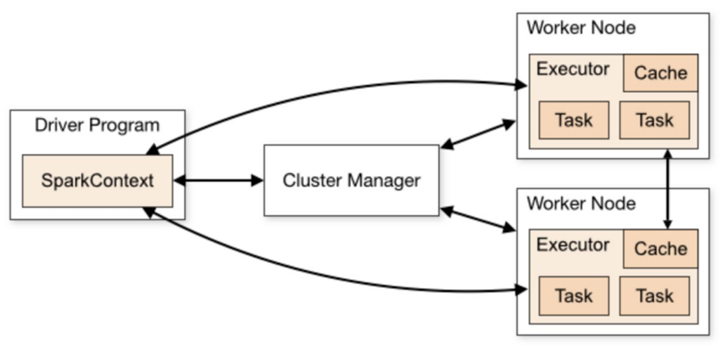
<br>

* Spark Context
  * 처리의 역할만 하고, 데이터를 읽고 Cluster를 관리 등은 플러그인을 제공한 타 기능이 실행
  * 다양한 데이터 Source에 연결한 뒤, 데이터는 Job, Task가 나뉜 것에 따라 분배가 되어야하는데 Spark가 직접하지 않음
  * Hadoop이 이미 Distributed file system을 잘 구축해두었으므로(데이터 처리가 느리지만), 그대로 가져와서 사용
  * Spark를 설치해보면, 자동으로 HDFS가 자동으로 함께 설치됨(Dependency가 걸려있음)
  * **데이터 처리용도 외의 데이터를 자르거나 Job을 분배하는 처리는 다른 플랫폼을 활용한다**

## Spark Environment 설정(Docker사용)

* 클러스터의 무료 버전은 등록/제약(몇개월이내 데이터량) 등의 문제로 Local(Docker)에서 실습예정
<br>

* `Docker`
  * 어떤 환경을 쓰더라도, 다른 OS나 패키지 등의 상황에 대응하기 어려움 
    (→ 어떤 환경에서든 Application이 돌아갈 수 있도록 도와주는 Docker)
  * Virtual Machine이 OS단위 구현인 것과 달리, **하나의 OS에서 Docker엔진이 Software단위로 패키징**
    * OS커널은 다른 컨테이너와 공유할 수 있으며, 각 컨테이너는 격리된 프로세스로 실행
  * 수업은 Ubuntu를 활용하여 Docker Engine 설치
    * https://docs.docker.com/engine/install/ubuntu/
    * Ubuntu설치 : https://ubuntu.com/download/desktop
    * Ubuntu설치 Tutorial : https://ubuntu.com/tutorials/install-ubuntu-desktop#1-overview
  * Docker를 설치했다는 것은 Docker Engine을 설치했다는 것이고(하단그림 가로), 이제 위의 App(하단그림 세로)을 띄워야 함
    * 만들어져있는 App을 사용할 예정(Spark Driver, Spark Executer, Airflow, ES, Kibana, Jupyter 등) <br>
    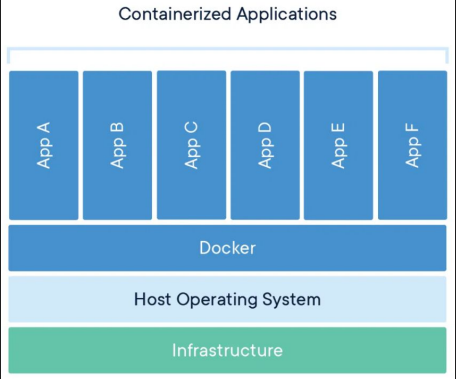
  * Docker파일(컨테이너화 하는 파일) : 내가 원하는 소프트웨어를 어떤 환경/버전/라이브러리로 설치할 것을 정의하는 파일
    * 하단 그림을 해석하자면, airflow 2.7.1, Python 3.11버전을 사용하고 싶음
      * From에서 제공하는 이미지를 가져와서 (airflow에서 Docker이미지를 제공함[Docker쓰는 경우가 많아서])
      * root 권한을 사용하여 apt-get을 update 후 python3-dev 등을 설치
      * JAVA_Home세팅을 내가 설치한 java-11-openjdk-arm64로 해줌
      * airflow 유저네임으로 바꿔서
      * airflow에서 사용할 python패키지 (apache-airflow 등) 설치
      * **From의 이미지만을 사용하면 원하는 JDK를 사용하기 어렵고, 파이썬 패키지가 없는 상태임**
      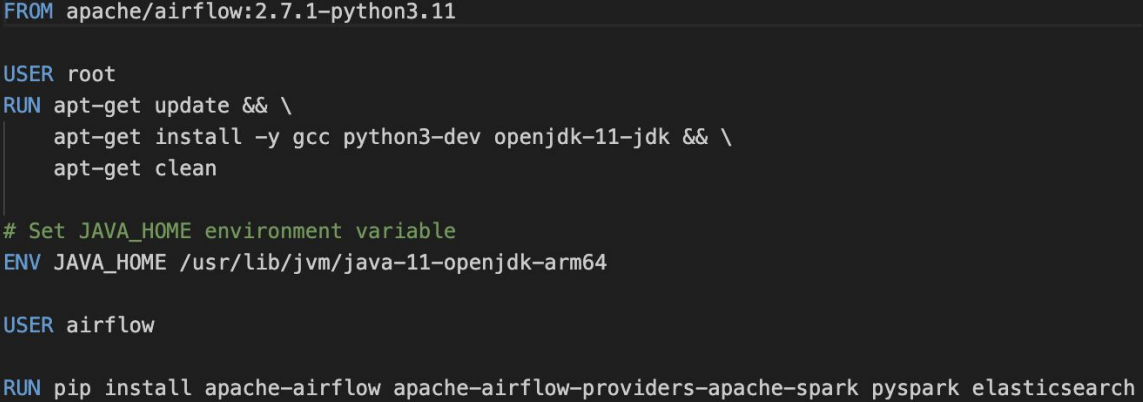 
    * **Docker파일은 정의된 config파일**로, 이것을 Docker이미지로 build하게 됨(build를 하면 이미지가 나옴)
      * docker build명령어로 config파일을 사용 
        * -t : 이름지정
        * -f로 파일명을 지정하지 않고(-f Dockerfile 등), .을 찍으면 현재 디렉토리기준으로 Docker파일을 만듦
        ```
          docker build -t airflow-python:20240805 .
        ```
      * 수업에서는 Docker-Compose를 사용할 예정으로 별도의 build를 진행하지 않음
  * **Docker이미지** : 컨테이너 App이 올라가기 전, 만들어져있는(올라가기 직전의) 명세
  * **Docker명령어 사용실습**
    ```wsl
      docker images  # Docker 이미지를 볼 수 있음
    ```
    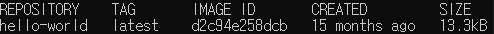
    ```wsl
      docker container ls  # 올라와있는(up되어있는) Docker container들을 볼 수 있음
                           # docker container까지만 치면 사용가능한 명령어를 보여줌
    ```
<br>

* `Docker Compose`
  * Docker 컨테이너 설정들을 한번에 관리하기 위한 기술 (docker설치시 같이 설치됨)
  * docker에서 실행(설치)하도록 하는 airflow제공 가이드 : https://airflow.apache.org/docs/apache-airflow/stable/howto/docker-compose/index.html
    * airflow는 여러 기능이 있으므로 컨테이너도 여러개 있음
  * spark를 기준으로 이해하자면, Driver를 뜨고  Worker(Node)를 뜨는 등 순서에 따라 진행하고, 모든 Node가 되는지 확인까지 compose로 진행
  * 하단 그림을 기준으로
    * Services에 여러 컨테이너를 띄울 것(spark-master, spark-worker)
    * spark-worker의 **`depends_on`: spark-master** : spark-master 뜬 다음에 진행하겠다는 의미
    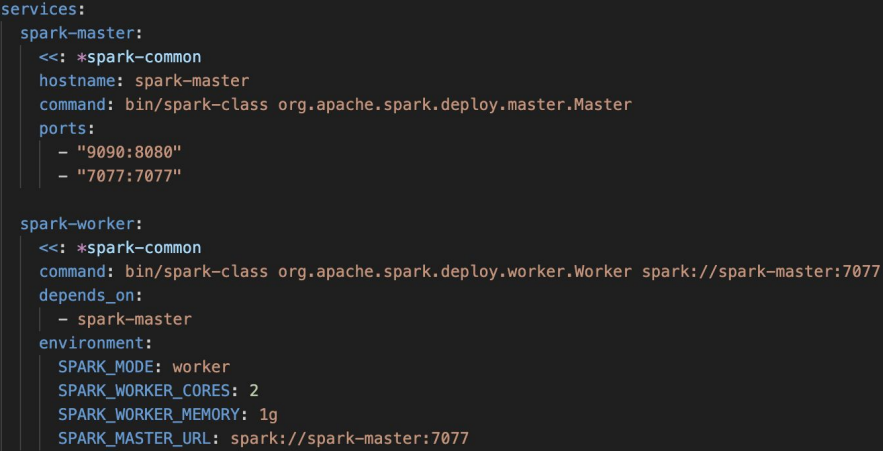
  * compose를 사용하지 않는다면 **컨테이너별로 명령어를 따로 쳐야하는 불편함. 이를 막을 수 있도록 docker-compose를 사용**
    * docker-compose.yml 파일에 정의해두고 사용

* `Docker Commands`
  * 기본 커맨드
    * docker-compose up -d  (start all the containers)
      * -d : 백그라운드에서 실행(터미널이 끌 수 없는 상태로 실행되는 것을 방지)
    * docker-compose down     (stop all the containers)
      * 참고 : stop되지 않은 컨테이너는 rm이 불가하다
    * docker ps             (check the containers)
      * start된 컨테이너를 보여줌
        * docker container ls (stop된 컨테이너도 모두 뜸)
    <br>
  
  * 디버깅이나 오류 상황등에서 사용하는 커맨드
    * docker logs <container name or id>   (check container logs)
      * 로그를 컨테이너별로 볼 수 있다
    * docker stop <container name or id>   (stop specific docker container)
    * docker rm <container name or id>     (remove specific docker container)
    * docker container ls -a               (check all the containers including stopped ones)
    * docker images (docker 이미지 목록)
  <br>
    * docker run --options <docker-image-name> (run docker image)
      * docker run -it de-2024_scheduler scheduler  (**-it 옵션으로, de-2024_scheduler를 실행**)
        * 이름을 지정하지 않으면 임의의 이름을 부여 (-name=)
      * docker run -it minz95/de2024:jupyter /bin/bash    
        * container마다 /bin/bash가 존재함을 단순 참고
    * docker rmi <docker-image-name>           (remove docker image)
      * **docker rm 등은 실제 이미지가 지워지는게 아니며**, docker rmi로 삭제
    * docker system prune                      (remove all the orphans in docker system)
      * cache 등 용량이 모자라면 사용(문제가 된 컨테이너가 계속 실행중인 경우 메모리가 쌓여있을 수 있음)
    * docker start <container id or name>
      * container 실행
    * docker exec -it <container id or name> /bin/bash (execute docker container)
      * container에 들어가서 볼 수 있음
      * exit를 입력하여 종료 가능

  <br>
  
  * Docker에서 Spark-Master를 잘 실행했다면, `http://localhost:9090/` 를 입력하여 확인 가능
    * 하단 yml파일에 ports세팅을 해두었기 때문에 9090으로 접속 가능
  * docker-compose.yml 파일
    ```yaml
      services:
        spark-master:
          <<: *spark-common
          hostname: spark-master
          command: bin/spark-class org.apache.spark.deploy.master.Master
          expose:
            - "7077"
          ports:
            - "9090:8080" # UI
            - "7077:7077" # Master와 직접연결
            - "4444:4040"
    ```
<br>

* 직접 Spark를 설치한다면 필요한 사항
  * Java 8  이상이 설치된 Linux 서버
  * Spark 다운로드
  * Spark 홈페이지 -> Download 페이지
  * 원하는 버젼 선택 후 다운로드
  * 스파크 설치, 압축 해제
  * 각자의 환경에 맞는 config 설정하기
  * 링크 : https://spark.apache.org/docs/latest/configuration.htm

## Submitting Spark Job

* Spark Application
  * Build-in Application : Spark에서 기본 제공
  * User-Built Application : User가 작성
<br>

* Spark Application 작성순서
  * SparkContext(SparkSession)생성
    ```
        spark = SparkSession.builder.getOrCreate()
    ```
  * 데이터 모델 생성(DataFrame/Dataset, RDD)
    ```
        df = spark.read.format("csv").option("header", True).load(csv_file)
    ```
  * 데이터 처리 : Where절 등 사용
    ```
        result = df.withColumn('rate', col("rate").cast(DoubleType()))
    ```
  * 결과 파일 처리
    ```
        result.show(3, false)
    ```
<br>

* Spark Application 실습 (Word-Count)
  * 과정
    1. 서버 준비
    2. 파일을 나누어 서버에 분산시켜 전송 (HDFS가 진행)
    3. 프로그램 빌드 (내가 진행)
    4. 빌드한 프로그램을 서버에 전송 (Cluster Manager가 진행)
    5. 서버 별로 실행 결과 기록 (Spark가 진행)
    6. 모든 결과를 더해서 최종 결과 추출  (Spark가 진행)
  * 코드
    ```python
    from pyspark.sql import SparkSession

    spark = (
        SparkSession.builder
            .appName("word-count")
            .master("local")
            .getOrCreate()
    )
    sc = spark.sparkContext

    text = "Hello Spark Hello Python Hello Docker Hello World"
    words = sc.parallelize(text.split(" "))
    wordCounts = words.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

    for wc in wordCounts.collect():
        print(wc[0], wc[1])

    spark.stop()
    ```
<br>

* RDD(Resilient Distributed Dataset)
  * 위의 실습코드의 `parallelize`로 사용한 것이 RDD라는 모델
  * 분산 데이터 모델
  * MapReduce와 비슷한 역할 (MR용도에 최적화된, 그러나 하둡보다는 발전한)
  * How를 기술 (데이터를 어떻게 조작할지를 기술)
    ```
      rdd.map((_., 1L))
      rdd.reduceByKey(_ + _)
    ```
    * 참고 : pandas DataFrame은 How가 아닌 What을 기술(어떤 작업을 할지 컬럼별로 기술)
      * **RDD는 컬럼이 없는 데이터 모델**
<br>

* Cluster Manager
  * Node 상태를 체크해서 작업을 분배, 죽은 Node를 제외하는 등 기능 필요
* Driver (Spark Context가 뜨는 Node)
  * 백그라운드 프로세스와 정보들 관리
  * Cluster Manager와 관계없이 동작 (Cluster Manager가 보는 상태는 Executor의 상태, Driver를 좌우하지 않음)
    * Cluster Manager와 정보는 공유함
* Executor
  * (Cluster manager의)Scheduler로부터 task를 할당받아 실행하는 역할
<br>

* `Spark-submit`
  * Spark실행때는 파이썬 명령어로 실행할 수 없음 (python test.py 등)
    * 빌드한 프로그램을 각 서버(띄운 Worker에서 실행하도록) 명령을 보내주어야 함
    * 이 내용이 Built-in application 중 `spark-submit`임
      ```
        spark-submit --master=<yarn|mesos…> 
      ```
  * `Spark-submit을 하면 전체 Worker node에 job을 분배해줌`
  * 코드 샘플 (수업은 Local환경임을 참고)
    * spark-master : yml파일 참고하여 작성함
      * spark-master : hostname
      * :7077 : master와 연결할 ports
    ```
      spark://spark-master:7077
    ```
    * docker-compose.yml
      ```yaml
      services:
        spark-master:
          <<: *spark-common
          hostname: spark-master
          command: bin/spark-class org.apache.spark.deploy.master.Master
          expose:
            - "7077"
          ports:
            - "9090:8080" # UI
            - "7077:7077" # Master와 직접연결
            - "4444:4040"
      ```
<br>

* `Spark Context`
  * Spark Context를 생성해야 Spark Task를 실행할 수 있음
    * Initialize Environment의 역할
  * **Spark Context는 매번 생성하므로 공통 함수가 있으면 편리함**
<br>

* `Spark Session`
  * Spark Session은 Spark Context를 코딩하기 쉽게 래핑해둔 것으로 이해
    * Spark Context가 Spark Session에 들어있다
  * Low level 작업(RDD 등)을 할 때는 SparkContext를 사용
  * SparkContext도 Spark Session을 통해 접근할 수 있음
<br>

* Spark Submission Command
  * [예시] 하단 코드를 기준으로
    * `-it` option으로 `spark-submit`을 실행
    * `--master` option으로 spark-master의, 7077로 지정
    * `<python-app-path>`안에 파이썬 파일명
    * 파이썬 파일이 파라미터를 받는다면 `<data-path>`을 지정
  ```
  docker exec -it de-2024-spark-master-1 spark-submit --master spark://spark-master:7077 <python-app-path> <data-path>
  ```
  * [방법1] docker에서 실행 (실습환경 기준)
    * jobs에 대한 매핑이 이미 되어있기에 가능함을 참고 (yml파일의 x-spark-common의 volumns 부분)
    * 아래 파이썬 파일(word-count.py)은 파라미터를 받지 않음
  ```
  docker exec -it de-2024-spark-master-1 spark-submit --master spark://spark-master:7077 jobs/word-count.py
  ```
  * [방법2] 컨테이너에 들어간 후 실행 (실습환경 기준)
    * 아래 파이썬 파일(hello-world.py)은 파라미터를 받음
  ```yaml
  # 해당 컨테이너에 들어감
  docker exec -it de-2024-spark-master-1 /bin/bash
  # 파일이 있는 폴더로 들어감
  cd jobs
  # 해당 폴더에서 직접 실행 
  spark-submit --master spark://spark-master:7077 hello-world.py ..data/movies.csv
  ```

## Pyspark

* Pyspark는 Main은 아님
  * Spark는 Scala로 구현되어있어, 신기능은 Scala로 먼저 개발됨
  * Python으로 포팅되기까지 시간이 걸림

* Scala가 필수는 아님
  * Scala는 함수형 프로그래밍에 대한 부담이 큼
  * Spark 자체가 다양한 언어를 지원하여, 간단한 처리로는 어떤 언어도 가능

* 단 아래의 경우는 Scala가 필요함
  * 최신 Spark API가 필요하거나 Customizing이 필요한 경우
  * 성능최적화나 오픈소스 등을 기여하고자 할 때
  * Spark 내부구조를 분석해서 디버깅해야할 Case가 있을 때

## Dataset

* [참고]실습 데이터 폴더구조
  * dags : airflow에서 사용
  * data : 데이터를 넣고 사용
  * es-data : elastic search에서 사용
  * jobs : 주로 사용할 메인코드, spark 코드 사용
  * logs : airflow 로그용 디렉토리
  * notebooks : jupyernotebook 파일
  * resources : elasticsearch jar파일

* 과제 데이터셋 고민
  * Yahoo Finance API
  ```python
    import yfinance as yf 
    msft = yf.Ticker("MSFT")
    msft.info
    # get historical market data 
    hist = msft.history(period="1mo")
    # show meta information about the history (requires history() to be called first) 
    msft.history_metadata
  ```

* 데이터의 Schema 확인하는 샘플코드
  ```
  df = spark.read.csv('')
  df.printSchema()
  ```

## Spark Materials

* https://spark.apache.org/docs/latest/
* https://databricks.com/blog/category/engineering/spark
* spark 를 이루는 기반 기술에 대한 공부  (java I/O, python, Hadoop)